In [238]:
import pickle
import sklearn
import modAL
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import margin_sampling
import sys
import os

import pandas as pd
import csv

# import audio_decryption
import librosa
import IPython.display
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
path_project = '/beegfs/yw3004/projects/ismir2018_LBD/'

# 1. Load training data

In [307]:
X_train = pickle.load(open(os.path.join(path_project + 'X_train.pickle'), "rb" ))
y_train = pickle.load(open(os.path.join(path_project + 'y_train.pickle'), "rb" ))
X_val = pickle.load(open(os.path.join(path_project + 'X_val.pickle'), "rb" ))
y_val = pickle.load(open(os.path.join(path_project + 'y_val.pickle'), "rb" ))
X_test = pickle.load(open(os.path.join(path_project + 'X_test.pickle'), "rb" ))
y_test = pickle.load(open(os.path.join(path_project + 'y_test.pickle'), "rb" ))

X_pool = pickle.load(open(os.path.join(path_project + 'X_pool.pickle'), "rb" ))
key_pool = pickle.load(open(os.path.join(path_project + 'key_pool.pickle'), "rb" ))

# 2. Initial classifier

In [270]:
clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)
score = np.mean(clf.predict(X_test) == y_test)
print('accuracy:', score)

accuracy: 0.6724137931034483


In [271]:
pred = clf.predict(X_test)
starting_precision = precision_score(y_test,pred)
starting_recall = recall_score(y_test,pred)
starting_confusion_matrix = confusion_matrix(y_test,pred)
print(starting_precision)
print(starting_recall)
print(starting_confusion_matrix)

0.7333333333333333
0.5761904761904761
[[304  88]
 [178 242]]


In [272]:
with open(os.path.join(path_project, 'models', 'model_initial.pickle'), 'wb') as f:
    pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)

# 3. Active Learning

In [198]:
learner = ActiveLearner(
    estimator=clf,
    query_strategy=modAL.uncertainty.margin_sampling,
    X_training=X_train, y_training=y_train
)

In [199]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [251]:
def active_learning(X_pool, key_pool, n_queries, n_instances, threshold, converge_cond):
    precision = [starting_precision]
    recall = [starting_recall]
    confusion_matrices = [starting_confusion_matrix]
    count = 1
    queries = {}
    not_converge = True
    
    while count < n_queries+1 and not_converge:
        y = []
        query_idx, query_instance = learner.query(X_pool, n_instances=n_instances)
        for i in range(n_instances):
            key = key_pool[query_idx[i]][0]
            filepath = os.path.join(path_project, 'fma-audio', str(key) +'.ogg')
            
            y_track, sr = librosa.core.load(filepath)
            IPython.display.display(IPython.display.Audio(data=y_track, rate=sr))

            y_new = input("Please input label for\nsample_key = '%s' (1 if saxophone is present, 0 if saxophone is not present)" % (key))
            y.append(int(y_new))
            
            queries[key] = int(y_new)
            
        print('ARRAY: ',y)
        learner.teach(
            X=X_pool[query_idx],
            y=np.array(y).reshape(-1, ))
    
        X_pool = np.delete(X_pool, query_idx, axis=0)
        key_pool = np.delete(key_pool, query_idx, axis=0)
        
        prediction_probabilities = learner.predict_proba(X_val)
        
        prediction = adjusted_classes(prediction_probabilities[:,1], threshold)
        
        precision.append(precision_score(y_val,prediction))
        recall.append(recall_score(y_val,prediction))
        confusion_matrices.append(confusion_matrix(y_val,prediction))
    
        print('Precision after query no. %d: %f' % (count, precision_score(y_val,prediction)))      
        print(precision[count]-precision[count-1])
        print('Recall after query no. %d: %f' % (count, recall_score(y_val,prediction))) 
        
        if len(precision) > 4 and np.abs(precision[count]-precision[count-1]) < converge_cond \
        and np.abs(precision[count-1]-precision[count-2]) < converge_cond \
        and np.abs(precision[count-2]-precision[count-3]) < converge_cond \
        and np.abs(recall[count]-recall[count-1]) < converge_cond \
        and np.abs(recall[count-1]-recall[count-2]) < converge_cond \
        and np.abs(recall[count-2]-recall[count-3]) < converge_cond:
            not_converge = False
        
        with open(os.path.join(path_project, 'models', 'model'+'_iter_'+ str(count) +'.pickle'), 'wb') as f:
            pickle.dump(learner, f, protocol=pickle.HIGHEST_PROTOCOL)
        count += 1
    
    return queries, precision, recall, confusion_matrices

In [250]:
active_learning(X_pool, key_pool, 10, 1, 0.5, 10e-4)

Please input label for
sample_key = '009748_65280' (1 if saxophone is present, 0 if saxophone is not present)1
ARRAY:  [1]
Precision after query no. 1: 0.781421
0.0480874316939891
Recall after query no. 1: 0.578947


Please input label for
sample_key = '011090_96000' (1 if saxophone is present, 0 if saxophone is not present)0
ARRAY:  [0]
Precision after query no. 2: 0.792350
0.010928961748633892
Recall after query no. 2: 0.587045


Please input label for
sample_key = '053204_65280' (1 if saxophone is present, 0 if saxophone is not present)0
ARRAY:  [0]
Precision after query no. 3: 0.774011
-0.018338427340928054
Recall after query no. 3: 0.554656


Please input label for
sample_key = '006585_149760' (1 if saxophone is present, 0 if saxophone is not present)0
ARRAY:  [0]
Precision after query no. 4: 0.805882
0.03187105350614827
Recall after query no. 4: 0.554656


Please input label for
sample_key = '000046_3840' (1 if saxophone is present, 0 if saxophone is not present)0
ARRAY:  [0]
Precision after query no. 5: 0.814371
0.008488904543853426
Recall after query no. 5: 0.550607


Please input label for
sample_key = '001755_0' (1 if saxophone is present, 0 if saxophone is not present)0
ARRAY:  [0]
Precision after query no. 6: 0.750000
-0.06437125748502992
Recall after query no. 6: 0.534413


Please input label for
sample_key = '025214_23040' (1 if saxophone is present, 0 if saxophone is not present)0
ARRAY:  [0]
Precision after query no. 7: 0.793478
0.04347826086956519
Recall after query no. 7: 0.591093


Please input label for
sample_key = '000726_72960' (1 if saxophone is present, 0 if saxophone is not present)0
ARRAY:  [0]
Precision after query no. 8: 0.753927
-0.03955155929888454
Recall after query no. 8: 0.582996


Please input label for
sample_key = '022983_226560' (1 if saxophone is present, 0 if saxophone is not present)0
ARRAY:  [0]
Precision after query no. 9: 0.820809
0.06688254698423268
Recall after query no. 9: 0.574899


Please input label for
sample_key = '001999_53760' (1 if saxophone is present, 0 if saxophone is not present)0
ARRAY:  [0]
Precision after query no. 10: 0.805714
-0.015094962840627613
Recall after query no. 10: 0.570850


({'009748_65280': 1,
  '011090_96000': 0,
  '053204_65280': 0,
  '006585_149760': 0,
  '000046_3840': 0,
  '001755_0': 0,
  '025214_23040': 0,
  '000726_72960': 0,
  '022983_226560': 0,
  '001999_53760': 0},
 [0.7333333333333333,
  0.7814207650273224,
  0.7923497267759563,
  0.7740112994350282,
  0.8058823529411765,
  0.8143712574850299,
  0.75,
  0.7934782608695652,
  0.7539267015706806,
  0.8208092485549133,
  0.8057142857142857],
 [0.5761904761904761,
  0.5789473684210527,
  0.5870445344129555,
  0.5546558704453441,
  0.5546558704453441,
  0.5506072874493927,
  0.5344129554655871,
  0.5910931174089069,
  0.582995951417004,
  0.5748987854251012,
  0.5708502024291497],
 [array([[304,  88],
         [178, 242]]), array([[233,  40],
         [104, 143]]), array([[235,  38],
         [102, 145]]), array([[233,  40],
         [110, 137]]), array([[240,  33],
         [110, 137]]), array([[242,  31],
         [111, 136]]), array([[229,  44],
         [115, 132]]), array([[235,  38],
      

# 4. Predicted score distribution #

In [268]:
def pred_score_dist(model_path):
    model = pickle.load(open(model_path, "rb" ))

    pred_prob = model.predict_proba(X_val)
    y_val_array = y_val.reshape(-1,1)
    score_dist = np.concatenate((pred_prob, y_val_array),axis=1)
    
    true_pos_scores = []
    true_neg_scores = []
    for score in score_dist:
        if score[2] == 1:
            true_pos_scores.append(score[1])
        else:
            true_neg_scores.append(score[1])
#     return true_pos_scores, true_neg_scores
    plt.hist(true_pos_scores,100, alpha=0.5, edgecolor='k', label='true positives')
    plt.hist(true_neg_scores,100, alpha=0.5, edgecolor='k', label='true negatives')
    plt.legend(loc='best', fontsize=15)
    plt.xlabel('Predicted probability of being positive', fontsize=15)
    plt.ylabel('Counts', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(0,1)
    plt.show()

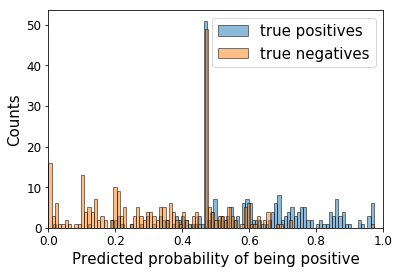

In [273]:
pred_score_dist(os.path.join(path_project, 'models', 'model_initial.pickle'))

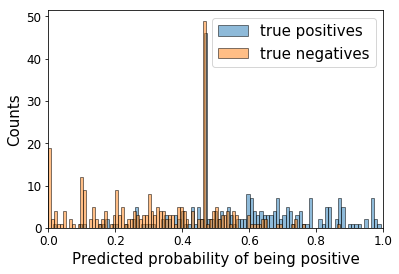

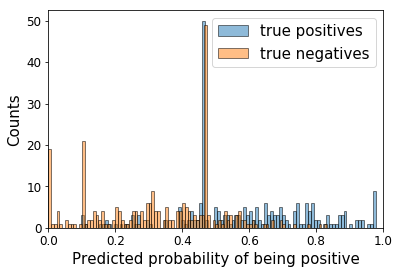

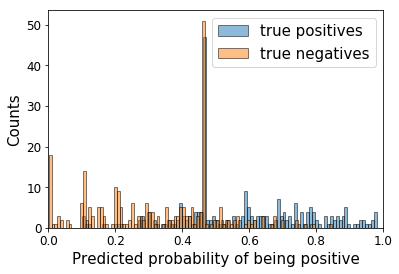

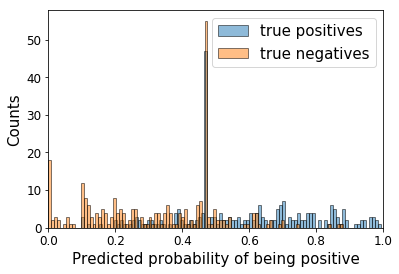

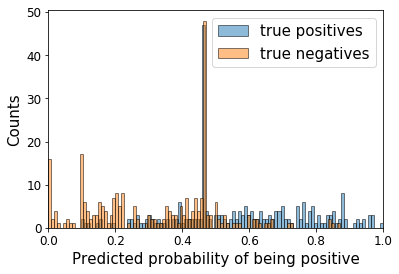

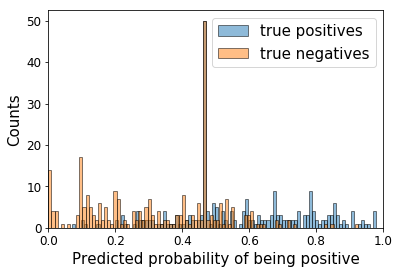

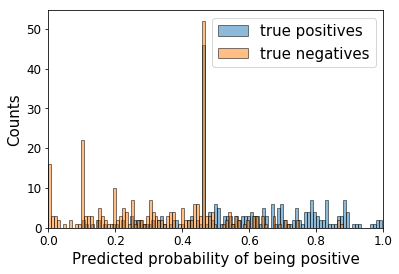

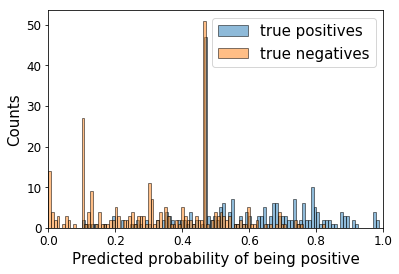

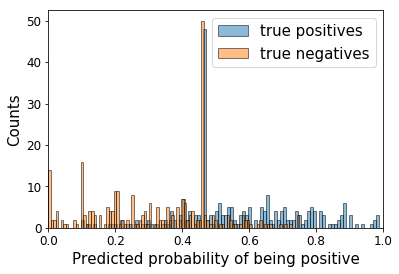

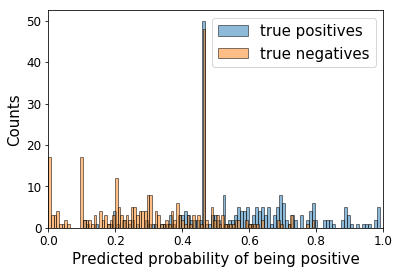

In [269]:
for i in range(1,11):
    model_path = os.path.join(path_project, 'models', 'model_iter_'+str(i)+'.pickle')
    pred_score_dist(model_path)

## Need modification

In [118]:
pos_in, neg_in = pred_score_dist('/scratch/yw3004/sonyc/sonyc_distortion_classification/models/model_initial.pickle')
pos_2, neg_2 = pred_score_dist(os.path.join(model_floder+'model_2_iter_'+str(2)+'.pickle'))
pos_10, neg_10 = pred_score_dist(os.path.join(model_floder+'model_2_iter_'+str(10)+'.pickle'))
pos_20, neg_20 = pred_score_dist(os.path.join(model_floder+'model_2_iter_'+str(20)+'.pickle'))
pos_50, neg_50 = pred_score_dist(os.path.join(model_floder+'model_2_iter_'+str(50)+'.pickle'))
pos_100, neg_100 = pred_score_dist(os.path.join(model_floder+'model_2_iter_'+str(100)+'.pickle'))

Text(0.5,1,'100 iterations')

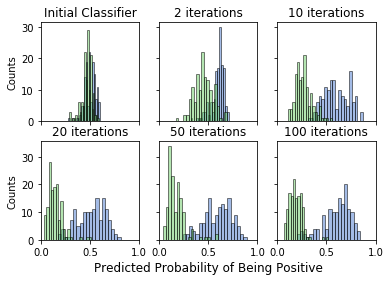

In [127]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')
ax1.hist(pos_in,20, alpha=0.5, edgecolor='k', label='true positives')
ax1.hist(neg_in,20, alpha=0.5, edgecolor='k', label='true positives')
ax1.set_title('Initial Classifier')
ax1.set_ylabel('Counts')
ax1.set_xlim(0,1)
ax2.hist(pos_2,20, alpha=0.5, edgecolor='k', label='true positives')
ax2.hist(neg_2,20, alpha=0.5, edgecolor='k', label='true positives')
ax2.set_title('2 iterations')
ax2.set_xlim(0,1)
ax3.hist(pos_10,20, alpha=0.5, edgecolor='k', label='true positives')
ax3.hist(neg_10,20, alpha=0.5, edgecolor='k', label='true positives')
ax3.set_title('10 iterations')
ax3.set_xlim(0,1)
ax4.hist(pos_20,20, alpha=0.5, edgecolor='k', label='true positives')
ax4.hist(neg_20,20, alpha=0.5, edgecolor='k', label='true positives')
ax4.set_title('20 iterations')
ax4.set_ylabel('Counts')
ax5.hist(pos_50,20, alpha=0.5, edgecolor='k', label='true positives')
ax5.hist(neg_50,20, alpha=0.5, edgecolor='k', label='true positives')
ax5.set_title('50 iterations')
ax5.set_xlabel('Predicted Probability of Being Positive', fontsize=12)
ax6.hist(pos_100,20, alpha=0.5, edgecolor='k', label='true positives')
ax6.hist(neg_100,20, alpha=0.5, edgecolor='k', label='true positives')
ax6.set_title('100 iterations')
# plt.tight_layout()

# 5. F-measure (on val data) at each iteration #

In [277]:
def get_fmeasure_threshold(model, thresholds):
    fmeasures = []
    for threshold in thresholds:
        pred_proba = model.predict_proba(X_val)
        pred = adjusted_classes(pred_proba[:,1], threshold)
        pred = np.array(pred)
        fmeasures.append(f1_score(y_val, pred))
    
    fmeasure_best = max(fmeasures)
    threshold_best = thresholds[np.argmax(fmeasures)]
    return fmeasure_best, threshold_best

In [283]:
model_folder = os.path.join(path_project, 'models')
thresholds = np.arange(0.1,0.9,0.01)
fmeasure_bests = []
threshold_bests = []
model_initial = pickle.load(open(os.path.join(model_folder,'model_initial'+'.pickle'), "rb" ))
fmeasure_best_initial, threshold_best_initial = get_fmeasure_threshold(model_initial, thresholds)
fmeasure_bests.append(fmeasure_best_initial)
threshold_bests.append(threshold_best_initial)  
                                              
for i in range(1,11):
    model = pickle.load(open(os.path.join(model_floder,'model_iter_'+str(i)+'.pickle'), "rb" ))
    fmeasure_best, threshold_best = get_fmeasure_threshold(model, thresholds)
    fmeasure_bests.append(fmeasure_best)
    threshold_bests.append(threshold_best)

Text(0.5,0,'Training iterations')

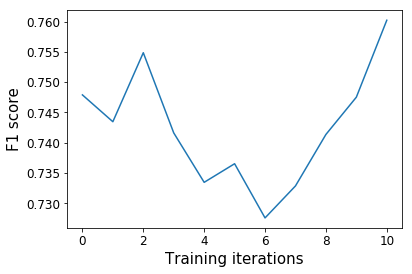

In [284]:
plt.plot(fmeasure_bests[:11])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('F1 score', fontsize=15)
plt.xlabel('Training iterations', fontsize=15)

In [285]:
best_fmeasure = max(fmeasure_bests)
best_iter = np.argmax(fmeasure_bests)
best_threshold = threshold_bests[best_iter]
print(best_fmeasure)
print(best_threshold)
print(best_iter)

0.7602131438721136
0.3999999999999998
10


# 6. Load best model#

In [286]:
best_model = pickle.load(open(os.path.join(model_folder,'model_iter_10.pickle'), "rb" ))

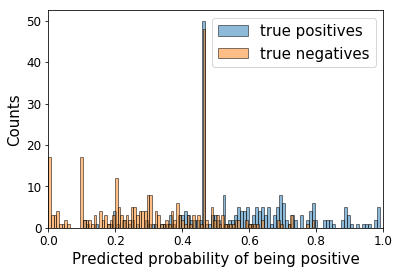

In [287]:
pred_score_dist(os.path.join(model_folder,'model_iter_10.pickle'))

## Val precision/recal

In [288]:
val_pred_prob = best_model.predict_proba(X_val)
val_pred = adjusted_classes(val_pred_prob[:,1], 0.4)
val_precision = precision_score(y_val, val_pred)
val_recall = recall_score(y_val, val_pred)
val_confusion_matrices = confusion_matrix(y_val, val_pred)
print(val_precision)
print(val_recall)
print(val_confusion_matrices)

0.6772151898734177
0.8663967611336032
[[171 102]
 [ 33 214]]


## Test prediction distribution, precision/recall

In [289]:
test_pred_prob = best_model.predict_proba(X_test)
# test_pred_prob = model_random.predict_proba(x_test)
y_test_ = y_test.reshape(-1,1)
test_score_dist = np.concatenate((test_pred_prob, y_test_),axis=1)

In [290]:
true_pos_scores = []
true_neg_scores = []
for score in test_score_dist:
    if score[2] == 1:
        true_pos_scores.append(score[1])
    else:
        true_neg_scores.append(score[1])

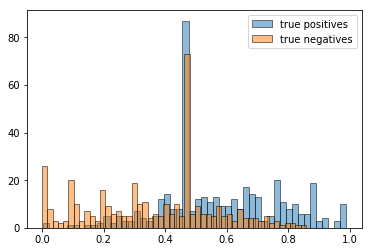

In [294]:
plt.hist(true_pos_scores,50, alpha=0.5, edgecolor='k', label='true positives')
plt.hist(true_neg_scores,50, alpha=0.5, edgecolor='k', label='true negatives')
plt.legend(loc='best')

In [295]:
test_pred = adjusted_classes(test_pred_prob[:,1], 0.32)
test_precision = precision_score(y_test, test_pred)
test_recall = recall_score(y_test, test_pred)
test_confusion_matrices = confusion_matrix(y_test, test_pred)
print(test_precision)
print(test_recall)
print(test_confusion_matrices)

0.6292682926829268
0.9214285714285714
[[164 228]
 [ 33 387]]


## Need modification

# 7. Get misclassified samples

In [202]:
def load_misclassified(model, x_test, y_test, threshold):
    test_pred_prob = model.predict_proba(x_test)
    test_pred = adjusted_classes(test_pred_prob[:,1], threshold)
    misclassified = np.where(y_test != test_pred)[0]
    for idx in misclassified:
        print(test_pred_prob[idx])
        print(y_test[idx])
        sensor_id = info_test[idx][0]
        timestamp = info_test[idx][1]
        frame = info_test[idx][2]
        date = audio_decryption.timestamp_to_date(timestamp)
        decrypt_path = os.path.join(audio_path_1, 'sonycnode-'+sensor_id+'.sonyc', date+'.tar')
        IPython.display.display(audio_decryption.decrypt_and_load_audio(decrypt_path, 
                                                                            sensor_id,
                                                                            timestamp, 
                                                                            sample_rate=44100, 
                                                                            frame=frame,
                                                                            url='https://decrypt-sonyc.engineering.nyu.edu/decrypt',
                                                                            cacert='/scratch/yw3004/sonyc/CA.pem', 
                                                                cert='/scratch/yw3004/sonyc/yuwang-decrypt.pem',
                                                                key='/scratch/yw3004/sonyc/<filename>_key.pem'))
        

In [303]:
load_misclassified(best_model, x_test, y_test, 0.33)

# 8. Draw random training data for comparison #

In [304]:
idx = list(range(0,random_X_pool.shape[0]))
random.shuffle(idx)
idx = idx[:102]
x_train = np.zeros((102,128))
y_train = np.zeros((102,1))
for i in range(len(idx)):
    x_train[i] = random_X_pool[idx[i]]
    sensor_id = random_info_pool[idx[i]][0]
    timestamp = random_info_pool[idx[i]][1]
    frame = int(random_info_pool[idx[i]][2])
    filepath = random_info_pool[idx[i]][3]
        
    try:
        decrypt_path = os.path.join(audio_path_1, filepath.split('/')[-2], filepath.split('/')[-1])
        IPython.display.display(audio_decryption.decrypt_and_load_audio(decrypt_path, 
                                                                            sensor_id,
                                                                            timestamp, 
                                                                            sample_rate=44100, 
                                                                            frame=frame, 
                                                                            url='https://decrypt-sonyc.engineering.nyu.edu/decrypt',
                                                                            cacert='/scratch/yw3004/sonyc/CA.pem', 
                                                                cert='/scratch/yw3004/sonyc/yuwang-decrypt.pem',
                                                                key='/scratch/yw3004/sonyc/<filename>_key.pem'))

    except FileNotFoundError:
        decrypt_path = os.path.join(audio_path_2, filepath.split('/')[-2], filepath.split('/')[-1]+'.gz')
        IPython.display.display(audio_decryption.decrypt_and_load_audio(decrypt_path, 
                                                                            sensor_id,
                                                                            timestamp, 
                                                                            sample_rate=44100, 
                                                                            frame=frame, 
                                                                            url='https://decrypt-sonyc.engineering.nyu.edu/decrypt',
                                                                            cacert='/scratch/yw3004/sonyc/CA.pem', 
                                                                cert='/scratch/yw3004/sonyc/yuwang-decrypt.pem',
                                                                key='/scratch/yw3004/sonyc/<filename>_key.pem'))
                                    
        
    label = input("Please input label for\nsensor_id = '%s'\ntimestamp = %s\nframe = %d (1 if noise is present, 0 if noise is not present)" % (sensor_id,timestamp,frame))
    y_train[i] = (int(label))

In [140]:
x_train.shape

(68, 128)

In [141]:
y_train.shape
y_train = np.ravel(y_train)

In [142]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)
with open('/scratch/yw3004/sonyc/sonyc_distortion_classification/models/random_model.pickle', 'wb') as f:
    pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)

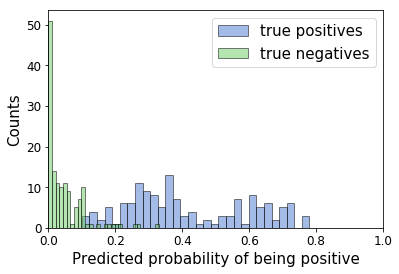

In [180]:
pred_score_dist('/scratch/yw3004/sonyc/sonyc_distortion_classification/models/random_model_2.pickle')

In [149]:
model_random = pickle.load(open('/scratch/yw3004/sonyc/sonyc_distortion_classification/models/random_model.pickle', "rb" ))

In [150]:
thresholds = np.arange(0.1,0.9,0.01)
f,t = get_fmeasure_threshold(model_random, thresholds)

/home/yw3004/miniconda3/envs/active_learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [152]:
t

0.20999999999999996

## Tune hyper parameters of random forest classifier

In [305]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, 200],
    'max_features': [2, 4, 16,64,128],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [2, 8, 10],
    'n_estimators': [100, 300, 500, 1000]
}
# Create a based model
clf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(x_test, y_test)
grid_search.best_params_